# Установка библиотек

In [1]:
import requests
from bs4 import BeautifulSoup

# Разработка парсера для сбора данных с рекомендованных веб-ресурсов

In [2]:
def get_pages_links(url:str, lists:list = [])->list:#Метод извлекает все ссылки с начальной страницы
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    try:
        lists.append(url)
        next_page_link = "https://habr.com" + soup.find('a', id='pagination-next-page')["href"]
        get_pages_links(next_page_link, lists)
    except:
        pass
    return lists

In [3]:
def get_posts_links_by_page_url(page_url: str)-> list: #Метод выполняет обход всех публикаций по извлеченным ссылкам
    posts_links = []
    response = requests.get(page_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    for post_link in soup.find_all('a', class_='tm-title__link'):
        link = "https://habr.com" + post_link["href"]
        posts_links.append(link)
    return posts_links

In [4]:
def get_all_posts_links(company_url):#Метод извлекает все ссылки с постов
    pages_links = get_pages_links(company_url)
    linkes = []
    for link in pages_links:
        linkes.append(get_posts_links_by_page_url(link))
    flat_list = [item for sublist in linkes for item in sublist]
    return list(set(flat_list))

In [5]:
def get_profile_info(profile_url)->dict:
    response = requests.get(profile_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    categories = soup.findAll("a", class_ = "tm-company-profile__categories-text")
    category_list = []
    for category in categories:
        category_list.append(category.get_text())
        
    data = {
        "rating_company" : soup.find("span", class_ = "tm-votes-lever__score-counter").get_text(),
        "desc_company" : soup.find("div", class_ = "tm-company-card__description").get_text(),
        "category_list_company" : category_list,
        "about_company" : soup.find("span", class_ = "tm-company-profile__content").get_text()
    }
    return data

В набор включены все предоставленные данные Набор данных дополнен информацией из аналитических статей Интернет-источников Определены и обоснованы наиболее значимые атрибуты

In [6]:
import re
def get_company_post_info(post_url):
    response = requests.get(post_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    tags_post = []
    tags = soup.findAll("a", class_ = "tm-article-snippet__hubs-item-link") 
    for tag in tags:
        tags_post.append(tag.get_text())
        
    labels_post = []
    labels = soup.findAll("div", class_ = "tm-article-snippet__label") 
    for label in labels:
        labels_post.append(label.get_text()) 
    tag = soup.find("span", class_="tm-article-complexity__label")
    if tag is not None:
        difficulty_post = tag.get_text()
    else:
        difficulty_post = "No label found"
    reading_time = soup.find("span", class_="tm-article-reading-time__label")
    if reading_time is not None:
        reading_time_post = re.findall(r'\d+', reading_time.get_text())[0]
    else:
        reading_time_post = "N/A"
        
    views_count = soup.find("span", class_="tm-icon-counter__value")
    if views_count is not None:
        views_count_post = re.findall(r'\d+\.\d+|\d+', views_count.get_text())[0]
    else:
        views_count_post = "N/A"
    data = {
        "name_post": soup.find("h1", class_ = "tm-title tm-title_h1").get_text(),
         "difficulty_post" : difficulty_post,
        "reading_time_post" : reading_time_post,
        "views_count_post" : views_count_post,
        "tags_post" : tags_post,
        "text_post" : soup.find("div", class_="tm-article-body").get_text()

    }
    return data

# Парсер выполняет обход всех публикаций по извлеченным ссылкам с начальной страницы

In [7]:
companies_urls = [
    "https://habr.com/ru/companies/avito"
]
posts = []
for company_url in companies_urls:
    urls_posts = get_all_posts_links(company_url + "/blog/")
    profile_company = get_profile_info(company_url +"/profile/")
    
    for url in urls_posts:
        post = get_company_post_info(url)
        post.update(profile_company)
        posts.append(post)

In [8]:
import pandas as pd
df = pd.DataFrame(posts)
df.head()

name_post difficulty_post  \
0  Centrifugo v2 — будущее сервера real-time сооб...  No label found   
1  Moscow SPA №4: краткое содержание, видео, през...  No label found   
2          CI/CD монолита Авито: от коммита до моржа  No label found   
3  Материалы митапа GOnline: дизайн библиотек, ко...  No label found   
4  Backend United #6: Табаско — разработчики о бе...  No label found   

  reading_time_post views_count_post  \
0                11               24   
1                 2              5.1   
2                 8              7.4   
3                 3                5   
4                 3              1.9   

                                           tags_post  \
0  [Блог компании AvitoTech , Разработка веб-сайт...   
1  [Блог компании AvitoTech , Разработка веб-сайт...   
2  [Блог компании AvitoTech , Программирование *,...   
3  [Блог компании AvitoTech , Go *, Машинное обуч...   
4  [Блог компании AvitoTech , Информационная безо...   

                                           text_post  \
0   Возможно, некоторые из читателей уже слышали ...   
1   Недавно в офисе Авито прошёл четвёртый по счё...   
2   Всем привет, меня зовут Александр Данковцев, ...   
3   Делимся материалами с нашего совместного мита...   
4   Привет! 25 июня в 18:00 по Москве пройдёт шес...   

             rating_company                 desc_company  \
0  \n        192.79\n        У нас живут ваши объявления   
1  \n        192.79\n        У нас живут ваши объявления   
2  \n        192.79\n        У нас живут ваши объявления   
3  \n        192.79\n        У нас живут ваши объявления   
4  \n        192.79\n        У нас живут ваши объявления   

                               category_list_company  \
0  [\n              Веб-разработка\n            ,...   
1  [\n              Веб-разработка\n            ,...   
2  [\n              Веб-разработка\n            ,...   
3  [\n              Веб-разработка\n            ,...   
4  [\n              Веб-разработка\n            ,...   

                                       about_company  
0  Мы команда инженеров Авито. В блоге рассказыва...  
1  Мы команда инженеров Авито. В блоге рассказыва...  
2  Мы команда инженеров Авито. В блоге рассказыва...  
3  Мы команда инженеров Авито. В блоге рассказыва...  
4  Мы команда инженеров Авито. В блоге рассказыва...

import pandas as pd
import json

with open('Gett.json',errors="ignore")as project_file: 
    data = json.load(project_file)  
with open('skillbox.json',errors="ignore")as project_file: 
    data = json.load(project_file)
with open('Здоровье.ру.json',errors="ignore")as project_file: 
    data = json.load(project_file)
with open('Иннотех.json',errors="ignore")as project_file: 
    data = json.load(project_file)
with open('gg.json',errors="ignore")as project_file: 
    data = json.load(project_file)
with open('Промобот.json',errors="ignore")as project_file: 
    data = json.load(project_file)

df2 = pd.json_normalize(data)

import pandas as pd
frames = [df1, df2]
  
df = pd.concat(frames)

# Парсинг веб-сайтов сохраняет полученные интернет-данные в файлы

In [9]:
import requests

# Выполняем GET-запрос к веб-сайту
response = requests.get('https://habr.com/ru/companies/avito')

# Проверяем успешность запроса
if response.status_code == 200:
    # Сохраняем содержимое ответа в текстовый файлЫ
    with open('example.html', 'w', encoding='utf-8') as f:
        f.write(response.text)
        print('Данные сохранены в файл example.html')
else:
    print('Ошибка при выполнении запроса:', response.status_code)

Данные сохранены в файл example.html


# В набор включены все предоставленные данные

In [10]:
df.columns

Index(['name_post', 'difficulty_post', 'reading_time_post', 'views_count_post',
       'tags_post', 'text_post', 'rating_company', 'desc_company',
       'category_list_company', 'about_company'],
      dtype='object')

In [11]:
unique_names = df["name_post"].unique()
unique_names

array(['Centrifugo v2 — будущее сервера real-time сообщений и библиотека для Go',
       'Moscow SPA №4: краткое содержание, видео, презентации, фотоотчёт',
       'CI/CD монолита Авито: от коммита до моржа',
       'Материалы митапа GOnline: дизайн библиотек, кодогенерация, машинное обучение',
       'Backend United #6: Табаско — разработчики о безопасности',
       'Kotlin Night Moscow в Avito 25 ноября',
       'Раннер Emcee. Всем айосерам по тестовой ферме',
       'Как устроено A/B-тестирование в Авито',
       'Как мы улучшили типографику на сайте Авито',
       'ClickHouse в Авито: посиделки в прямом эфире с Алексеем Миловидовым',
       'Эволюция поиска — как купить пианино в три клика',
       'Программировать хочу, пусть меня научат! Образовательные проекты Avito',
       'Управление секретами при помощи HashiCorp Vault',
       'Как мы переделали структуру собеседований, и что из этого вышло',
       'Тесты на знание Python, PHP, Golang и DevOps: разбор викторины AvitoQuiz н

# Дополняем набор данных информацией из аналитических статей Интернет-источников

In [12]:
len(unique_names)

331

# Преобразуем набор данных в требуемый формат

In [13]:
df.to_csv("init_dataset.csv", index=False)

# Формируем структуры набора данных

Для определения наиболее значимых атрибутов можно выделать два подхода:

1) выделение целвой перменной (номинация премии Рунета) и использование алгоритмов на основе деревьев (Random Forest, Gradient Boosting)

2) анализ корреляции (Correlation Analysis)

3) Знание предметной области и опыт

4) Исследовательский анализ данных (EDA) т.е. визуализация

Так как использвоание 1-2 и 4 пунктов невозиожно без подготовки данных, то впоспользуемся третьим способом.

Основной массив данных для определения тематика - это текст статей, опубликованных компаниями. В то же время, заголовок статьи и ее категории наиболее емко отражают сожержание.

Поэтому логично, что наиболее важными атрибутами являются:

-текст статьи (text_post)

-название статьи (name_post)

-категории статьи (category_list_company)

In [14]:
NOMINATIONS = [
    "Государство и Общество",
    "Культурные проекты в сети",
    "Народов много - Родина одна",
    "Образование и Кадры",
    "Наука, технологии и инновации",
    "Туризм и индустрия гостеприимства",
    "Экономика и Бизнес",
    "Здоровье и медицина",
    "Туризм и индустрия гостеприимства",
    "Подкасты и цифровой контент"
    ]

В датасет дополнительно были добавлены следующие атрибуты:

difficulty_post - сложность понимания поста

reading_time_post - время чтения поста

views_count_post - кол-во просмотров

tags_post - теги постов

rating_company - райтинг постов

desc_company - описание комапнии

category_list_company - категории компании

Атрибуты difficulty_post, reading_time_post, views_count_post, rating_company не окажут сильного влияния на целевую переменную, тем не менее будет интресно посмотреть на различные зависимости кластеров от этих атрибутов.

category_list_company, desc_company могут оказать влияние на целевую переменную


# Предварительная обработка данных

Выполняем разведочный анализ данных для составления плана предварительной обработки данных

Удалим пока аттрибуты представленные списками

In [15]:
df_explore = df[['name_post', 'difficulty_post', 'reading_time_post', 'views_count_post',
       'text_post', 'rating_company',
       'desc_company', 'about_company']]

In [ ]:
pip install wordcloud

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\profi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Shape of the DataFrame: (332, 10)
Columns in the DataFrame: Index(['name_post', 'difficulty_post', 'reading_time_post', 'views_count_post',
       'tags_post', 'text_post', 'rating_company', 'desc_company',
       'category_list_company', 'about_company'],
      dtype='object')
Data types of the columns:
 name_post                object
difficulty_post          object
reading_time_post        object
views_count_post         object
tags_post                object
text_post                object
rating_company           object
desc_company             object
category_list_company    object
about_company            object
dtype: object
Summary statistics of the DataFrame:
                       name_post difficulty_post reading_time_post  \
count                       332             332               332   
unique                      331               3                28   
top     И снова 256-й день года  No label found                 2   
freq                          2             3

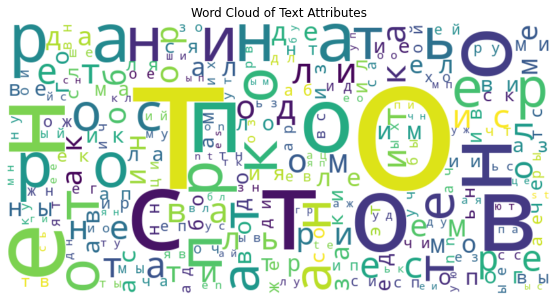

In [16]:
import nltk
nltk.download('stopwords')
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud



# Исследование базовых данных
print("Shape of the DataFrame:", df.shape)  # Получиаем количество строк и столбцов
print("Columns in the DataFrame:", df.columns)  # Получиаем имена столбцов
print("Data types of the columns:\n", df.dtypes)  # Получаем типы данных столбцов
print("Summary statistics of the DataFrame:\n", df.describe())  # Получаем сводную статистику

# Исследуем текстовые данные
# Выполняем задачи поиска текстовых данных, такие как подсчет слов, количество уникальных слов и т.д.
# Количество слов
df['word_count'] = df['text_post'].apply(lambda x: len(str(x).split()))
print("Word count statistics:\n", df['word_count'].describe())

# Количество уникальных слов
df['unique_word_count'] = df['text_post'].apply(lambda x: len(set(str(x).split())))
print("Unique word count statistics:\n", df['unique_word_count'].describe())

# Количество стоп-слов
stopwords_list = set(stopwords.words('russian'))  # Update with appropriate language
df['stopword_count'] = df['text_post'].apply(lambda x: len([word for word in str(x).lower().split() if word in stopwords_list]))
print("Stopword count statistics:\n", df['stopword_count'].describe())

# Визуализация данных
# Используя различные библиотеки построения графиков, такие как Matplotlib и WordCloud, для визуализации текстовых данных
# Примеры графиков:
# Облако слов
text = ' '.join(str(df['text_post'].values))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Attributes')
plt.show()

Как видно, разведочный анализ показвает, что в тексте мнодество стом слов. В среднем примерно 1200 слов в каждом посте при этом окло 400 стоп-слов в кажом посте.

# Выявяем и обработываем пропуски данных

Посмотрим наличик пустых значений и визуализируем

In [17]:
df.isna().sum()

name_post                0
difficulty_post          0
reading_time_post        0
views_count_post         0
tags_post                0
text_post                0
rating_company           0
desc_company             0
category_list_company    0
about_company            0
word_count               0
unique_word_count        0
stopword_count           0
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

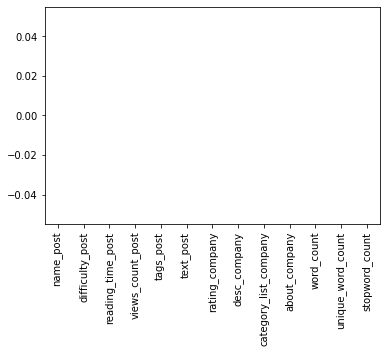

In [18]:
import matplotlib.pyplot as plt

df.isna().sum().plot(kind='bar')
plt.show


# Выбираем методы предварительной обработки данных

Так как мы работаем с текстовыми данными необходимо для них выполнить:

очистку данных

удаление стоп-слов

леммитизацию

векторизацию

Для отсальных колонок:

числа представленные в виде типа object перевести в численный вид данных

кодировать категории для дальшейшего обучения моделей

# Удаляем все лишние символы, кроме букв из текстов публикаций, Выполняем токенизацию текстов публикаций, Выполняем лемматизация текстов публикаций, Выполняем удаление спецсимволов из текстов публикаций, Удаляем все стоп-слова в тектах публикаций

В представленном коде используются несколько алгоритмов для предобработки текстов:

Удаление цифр: re.sub(r'\d+', '', text) - это регулярное выражение, которое удаляет все цифры из текста.

Удаление знаков пунктуации: re.sub(r'[^\w\s]', '', text) - это регулярное выражение, которое удаляет все знаки пунктуации из текста, кроме букв и пробелов.

Удаление лишних пробелов: re.sub(r'\s+', ' ', text) - это регулярное выражение, которое заменяет последовательности из одного или более пробелов одним пробелом.

Удаление стоп-слов: text = [word for word in text.split() if word not in stop_words] - это код, который удаляет стоп-слова из текста. Список стоп-слов загружается из библиотеки NLTK с использованием stopwords.words('russian').

In [19]:
import string
def text_preprocessing(text):
    stop_words = set(stopwords.words('russian'))
    exclude = set(string.punctuation)

    text = text.rstrip().lower()
    text = re.sub(r'\n',' ', text) # удалить /n
    text = re.sub(r'\d+', '', text) # удалить цифры
    text = re.sub(r'[^\w\s]', '', text)# убрать знаки препинания
    text = re.sub(r'\s+', ' ', text) # удалите лишние пробелы
    text = [word for word in text.split() if word not in stop_words] # Удаляем стоп-слова

    return text
sentences = list(df['text_post'].apply(text_preprocessing))

In [20]:
df.head()

name_post difficulty_post  \
0  Centrifugo v2 — будущее сервера real-time сооб...  No label found   
1  Moscow SPA №4: краткое содержание, видео, през...  No label found   
2          CI/CD монолита Авито: от коммита до моржа  No label found   
3  Материалы митапа GOnline: дизайн библиотек, ко...  No label found   
4  Backend United #6: Табаско — разработчики о бе...  No label found   

  reading_time_post views_count_post  \
0                11               24   
1                 2              5.1   
2                 8              7.4   
3                 3                5   
4                 3              1.9   

                                           tags_post  \
0  [Блог компании AvitoTech , Разработка веб-сайт...   
1  [Блог компании AvitoTech , Разработка веб-сайт...   
2  [Блог компании AvitoTech , Программирование *,...   
3  [Блог компании AvitoTech , Go *, Машинное обуч...   
4  [Блог компании AvitoTech , Информационная безо...   

                                           text_post  \
0   Возможно, некоторые из читателей уже слышали ...   
1   Недавно в офисе Авито прошёл четвёртый по счё...   
2   Всем привет, меня зовут Александр Данковцев, ...   
3   Делимся материалами с нашего совместного мита...   
4   Привет! 25 июня в 18:00 по Москве пройдёт шес...   

             rating_company                 desc_company  \
0  \n        192.79\n        У нас живут ваши объявления   
1  \n        192.79\n        У нас живут ваши объявления   
2  \n        192.79\n        У нас живут ваши объявления   
3  \n        192.79\n        У нас живут ваши объявления   
4  \n        192.79\n        У нас живут ваши объявления   

                               category_list_company  \
0  [\n              Веб-разработка\n            ,...   
1  [\n              Веб-разработка\n            ,...   
2  [\n              Веб-разработка\n            ,...   
3  [\n              Веб-разработка\n            ,...   
4  [\n              Веб-разработка\n            ,...   

                                       about_company  word_count  \
0  Мы команда инженеров Авито. В блоге рассказыва...        2568   
1  Мы команда инженеров Авито. В блоге рассказыва...         405   
2  Мы команда инженеров Авито. В блоге рассказыва...        1740   
3  Мы команда инженеров Авито. В блоге рассказыва...         632   
4  Мы команда инженеров Авито. В блоге рассказыва...         426   

   unique_word_count  stopword_count  
0               1404             693  
1                313             113  
2               1065             476  
3                369             152  
4                309             121

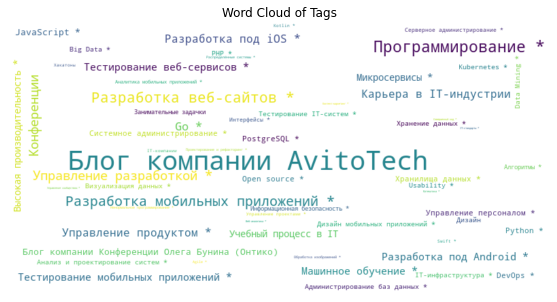

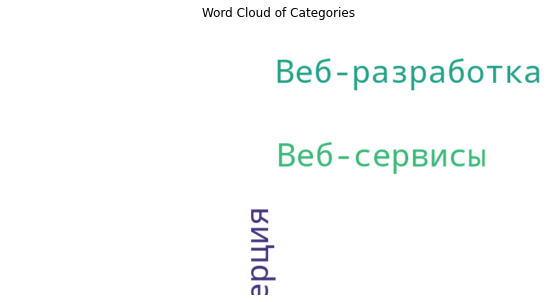

In [21]:
from collections import Counter
# Создаем облако тегов
tags = df['tags_post'].explode()
tags_counter = Counter(tags)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tags_counter)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tags')
plt.show()

# Создаем облако категорий
categories = df['category_list_company'].explode()
categories_counter = Counter(categories)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(categories_counter)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Categories')
plt.show()

In [ ]:
!pip install pymorphy2

In [22]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

In [23]:
#Удалены все лишние символы, кроме букв из текстов публикаций
def remove_special_chars(text):
    """
    Remove special characters and digits from text.
    """
    return re.sub(r'[^а-яА-Я\s]', '', text)

#Удалены все стоп-слова в тектах публикаций
def remove_stopwords(text):
    """
    Remove stop words from text.
    """
    stop_words = stopwords.words('russian')
    return ' '.join([word for word in text.split() if word not in stop_words])

# Выполнена лемматизация текстов публикаций
def lemmatize(text):
    """
    Lemmatize text using pymorphy2.
    """
    morph = MorphAnalyzer()
    return ' '.join([morph.parse(word)[0].normal_form for word in text.split()])

In [24]:
# Применяем функцию remove_special_chars() к столбцу с именем 'text_column'
df['text_clear'] = df['text_post'].apply(remove_special_chars)

# Применяем функцию remove_stopwords() к столбцу с именем 'text_column'
df['text_clear'] = df['text_clear'].apply(remove_stopwords)

# Применяем lemmatize() к столбцу с именем 'text_column'
df['text_clear'] = df['text_clear'].apply(lemmatize)

In [25]:
import nltk
nltk.download('punkt')  # Загружаем необходимые данные NLTK для токенизации

# Определяем функцию для обозначения русского текста с помощью NLTK
def tokenize_russian_text(text):
    tokens = nltk.word_tokenize(text, language='russian')
    return tokens

# Применяем функцию токенизации к столбцу "текст" во фрейме данных
df['tokens'] = df['text_clear'].apply(tokenize_russian_text)

# Отображаем результирующий фрейм данных
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\profi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


name_post difficulty_post  \
0  Centrifugo v2 — будущее сервера real-time сооб...  No label found   
1  Moscow SPA №4: краткое содержание, видео, през...  No label found   
2          CI/CD монолита Авито: от коммита до моржа  No label found   
3  Материалы митапа GOnline: дизайн библиотек, ко...  No label found   
4  Backend United #6: Табаско — разработчики о бе...  No label found   

  reading_time_post views_count_post  \
0                11               24   
1                 2              5.1   
2                 8              7.4   
3                 3                5   
4                 3              1.9   

                                           tags_post  \
0  [Блог компании AvitoTech , Разработка веб-сайт...   
1  [Блог компании AvitoTech , Разработка веб-сайт...   
2  [Блог компании AvitoTech , Программирование *,...   
3  [Блог компании AvitoTech , Go *, Машинное обуч...   
4  [Блог компании AvitoTech , Информационная безо...   

                                           text_post  \
0   Возможно, некоторые из читателей уже слышали ...   
1   Недавно в офисе Авито прошёл четвёртый по счё...   
2   Всем привет, меня зовут Александр Данковцев, ...   
3   Делимся материалами с нашего совместного мита...   
4   Привет! 25 июня в 18:00 по Москве пройдёт шес...   

             rating_company                 desc_company  \
0  \n        192.79\n        У нас живут ваши объявления   
1  \n        192.79\n        У нас живут ваши объявления   
2  \n        192.79\n        У нас живут ваши объявления   
3  \n        192.79\n        У нас живут ваши объявления   
4  \n        192.79\n        У нас живут ваши объявления   

                               category_list_company  \
0  [\n              Веб-разработка\n            ,...   
1  [\n              Веб-разработка\n            ,...   
2  [\n              Веб-разработка\n            ,...   
3  [\n              Веб-разработка\n            ,...   
4  [\n              Веб-разработка\n            ,...   

                                       about_company  word_count  \
0  Мы команда инженеров Авито. В блоге рассказыва...        2568   
1  Мы команда инженеров Авито. В блоге рассказыва...         405   
2  Мы команда инженеров Авито. В блоге рассказыва...        1740   
3  Мы команда инженеров Авито. В блоге рассказыва...         632   
4  Мы команда инженеров Авито. В блоге рассказыва...         426   

   unique_word_count  stopword_count  \
0               1404             693   
1                313             113   
2               1065             476   
3                369             152   
4                309             121   

                                          text_clear  \
0  возможно некоторый читатель слышать ранний в д...   
1  недавно офис авить прошлый четвртый счтить мит...   
2  весь привет звать александр данковец команда в...   
3  делиться материал наш совместный митапа сообще...   
4  привет июнь москва пройдт шестой митапа серия ...   

                                              tokens  
0  [возможно, некоторый, читатель, слышать, ранни...  
1  [недавно, офис, авить, прошлый, четвртый, счти...  
2  [весь, привет, звать, александр, данковец, ком...  
3  [делиться, материал, наш, совместный, митапа, ...  
4  [привет, июнь, москва, пройдт, шестой, митапа,...

In [ ]:
!python3 -m spacy download ru_core_news_sm
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [ ]:
pip install -U spacy

In [ ]:
!python -m spacy download ru_core_news_sm
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [26]:
import spacy
nlp = spacy.load("ru_core_news_sm")

In [ ]:
nltk.download('stopwords');

In [27]:
import spacy
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
# Загружаем данные в dataframe
# Определяем функцию для выполнения тегов частей речи и выделения значимых частей речи
def highlight_pos(text):
    doc = nlp(text)
    highlighted_text = ""
    for token in doc:
        if token.pos_ in ["NOUN", "VERB"]:   # Определяем значимые части речи
            highlighted_text += f"{token.text} " # Добавляем HTML-теги для выделения
    return highlighted_text

# Применяем функцию к столбцу маркированного текста во фрейме данных

df["highlighted_text"] = df["text_clear"].apply(highlight_pos)

# Распечатываем обновленный фрейм данных
df.head()

name_post difficulty_post  \
0  Centrifugo v2 — будущее сервера real-time сооб...  No label found   
1  Moscow SPA №4: краткое содержание, видео, през...  No label found   
2          CI/CD монолита Авито: от коммита до моржа  No label found   
3  Материалы митапа GOnline: дизайн библиотек, ко...  No label found   
4  Backend United #6: Табаско — разработчики о бе...  No label found   

  reading_time_post views_count_post  \
0                11               24   
1                 2              5.1   
2                 8              7.4   
3                 3                5   
4                 3              1.9   

                                           tags_post  \
0  [Блог компании AvitoTech , Разработка веб-сайт...   
1  [Блог компании AvitoTech , Разработка веб-сайт...   
2  [Блог компании AvitoTech , Программирование *,...   
3  [Блог компании AvitoTech , Go *, Машинное обуч...   
4  [Блог компании AvitoTech , Информационная безо...   

                                           text_post  \
0   Возможно, некоторые из читателей уже слышали ...   
1   Недавно в офисе Авито прошёл четвёртый по счё...   
2   Всем привет, меня зовут Александр Данковцев, ...   
3   Делимся материалами с нашего совместного мита...   
4   Привет! 25 июня в 18:00 по Москве пройдёт шес...   

             rating_company                 desc_company  \
0  \n        192.79\n        У нас живут ваши объявления   
1  \n        192.79\n        У нас живут ваши объявления   
2  \n        192.79\n        У нас живут ваши объявления   
3  \n        192.79\n        У нас живут ваши объявления   
4  \n        192.79\n        У нас живут ваши объявления   

                               category_list_company  \
0  [\n              Веб-разработка\n            ,...   
1  [\n              Веб-разработка\n            ,...   
2  [\n              Веб-разработка\n            ,...   
3  [\n              Веб-разработка\n            ,...   
4  [\n              Веб-разработка\n            ,...   

                                       about_company  word_count  \
0  Мы команда инженеров Авито. В блоге рассказыва...        2568   
1  Мы команда инженеров Авито. В блоге рассказыва...         405   
2  Мы команда инженеров Авито. В блоге рассказыва...        1740   
3  Мы команда инженеров Авито. В блоге рассказыва...         632   
4  Мы команда инженеров Авито. В блоге рассказыва...         426   

   unique_word_count  stopword_count  \
0               1404             693   
1                313             113   
2               1065             476   
3                369             152   
4                309             121   

                                          text_clear  \
0  возможно некоторый читатель слышать ранний в д...   
1  недавно офис авить прошлый четвртый счтить мит...   
2  весь привет звать александр данковец команда в...   
3  делиться материал наш совместный митапа сообще...   
4  привет июнь москва пройдт шестой митапа серия ...   

                                              tokens  \
0  [возможно, некоторый, читатель, слышать, ранни...   
1  [недавно, офис, авить, прошлый, четвртый, счти...   
2  [весь, привет, звать, александр, данковец, ком...   
3  [делиться, материал, наш, совместный, митапа, ...   
4  [привет, июнь, москва, пройдт, шестой, митапа,...   

                                    highlighted_text  
0  читатель слышать ранний дать статья речь пойти...  
1  офис авить четвртый счтить митапсателлит встре...  
2  привет звать команда статья рассказать построи...  
3  делиться материал митапа разработчик кат видео...  
4  привет июнь митапа серия название вещать онлай...

In [ ]:
pip install -U gensim

In [ ]:
pip install --upgrade numpy


-------------------------------------------------------------------------------------------------------------------------------

# Начало выполнения заданий модуля Б

-------------------------------------------------------------------------------------------------------------------------------

# Векторизация

In [28]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer


# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer to the text data
vectorizer.fit(df['text_clear'])




CountVectorizer()

#  Поиск ключевых слов/n-грамм. Векторизация текстов

Существует несколько способов поиска ключевых слов или n-грамм в текстовых данных. Вот три распространенных метода:


Регулярные выражения. Регулярные выражения — это мощный инструмент для поиска и обработки текста. Они позволяют искать шаблоны в текстовых данных, которые могут включать ключевые слова или n-граммы. Например, вы можете искать все экземпляры слова «кошка» в текстовом файле, используя регулярное выражение \bcat\b.

Мешок слов: модель мешка слов — это простой способ представления текстовых данных в виде вектора частоты слов. Вы можете использовать эту модель для поиска ключевых слов или n-грамм, ища наличие определенных слов или комбинаций слов в векторе. Например, вы можете искать все документы, содержащие слова «кошка» и слово «собака», используя модель мешка слов.

Модели n-грамм: Модель n-грамм — это статистическая языковая модель, которая предсказывает вероятность слова с учетом его предыдущих n-1 слов. Вы можете использовать эту модель для поиска n-грамм, ища наличие определенных n-грамм в текстовых данных. Например, вы можете искать все вхождения фразы «машинное обучение» в корпусе документов, используя модель n-грамм.

Использование статистических методов для обработки текстовых данных и выделения биграмм и триграмм имеет несколько преимуществ:




Улучшение качества обработки текстовых данных: выделение биграмм и триграмм позволяет захватить более глубокий контекст и смысл в текстовых данных, что может привести к более точным и полезным результатам при анализе текста.




Увеличение размера словаря: выделение биграмм и триграмм увеличивает размер словаря, что может улучшить качество моделей, основанных на текстовых данных, таких как моделирование тем или анализ тональности.




Улучшение скорости обработки: использование статистических методов для выделения биграмм и триграмм может ускорить обработку текстовых данных, поскольку это может уменьшить количество уникальных слов, которые необходимо обрабатывать.




Легкость в использовании: библиотеки, такие как Gensim, предоставляют простой и удобный способ выделения биграмм и триграмм в текстовых данных, что делает этот подход доступным и легким в использовании для широкого круга пользователей.

Модели n-грамм

In [29]:
# Импортируем необходимые библиотеки
import spacy
from nltk.corpus import stopwords
from gensim.models.phrases import Phrases

# Преобразуем объект WordList в список предложений
sentences = list(df['text_clear'])

# Создаем модели биграмм и триграмм с помощью функции Phrases из библиотеки Gensim
# min_count и threshold - параметры, которые контролируют, как часто должна встречаться фраза в тексте, чтобы быть рассмотренной как биграмма или триграмма
bigram = Phrases(sentences, min_count=5, threshold=100)
trigram = Phrases(bigram[sentences], min_count=5, threshold=100)

# Применяем модели к предложениям
for idx in range(len(sentences)):
    for token in bigram[sentences[idx]]:
        if '_' in token:
            # Токен - биграмма, добавляем в предложение
            sentences[idx].append(token)
    for token in trigram[bigram[sentences[idx]]]:
        if '_' in token:
               # Токен - триграмма, добавляем в предложение
            sentences[idx].append(token)
# Обновить столбец text_post предварительно обработанным текстом
df['text_bigram_trigram'] = sentences

этот код использует библиотеки Natural Language Toolkit (nltk) и Gensim для предварительной обработки текстовых данных в столбце pandas DataFrame с именем text_clear. Вот предпринимаемые шаги:

Преобразовывает столбец text_clear в список предложений.

Создавает модели биграмм и триграмм с помощью функции Phrases от Gensim, которая обнаруживает общие фразы (биграммы и триграммы) в текстовых данных.

Применяет модели биграммы и триграммы к каждому предложению в списке предложений, обнаруживая и добавляя к предложению любые токены биграммы или триграммы.


Конечным результатом является список предварительно обработанных предложений, которые были преобразованы для включения токенов биграммы и триграммы. Эти маркеры могут помочь получить больше контекста и смысла в текстовых данных, что может быть полезно для последующих задач, таких как моделирование темы или анализ тональности.

модель мешка слов

In [35]:
bow_matrix = vectorizer.transform(df['text_clear'])

# Вывод на экран признаков и матрицы мешка слов
print("Признаки:", vectorizer.get_feature_names())
print("Матрица мешка слов:\n", bow_matrix.toarray())

Признаки: ['аа', 'ааа', 'аааа', 'аааавтомобиль', 'аатест', 'аатестахлинейный', 'аатестепроверка', 'аба', 'аббревиатура', 'абзац', 'абзацамиполный', 'аблей', 'абракадабра', 'абсолютно', 'абсолютный', 'абстрагировать', 'абстрагироваться', 'абстрактно', 'абстрактный', 'абстракцийести', 'абстракция', 'абсурдный', 'абтест', 'абтестирование', 'абэнд', 'ава', 'авангард', 'авантюра', 'авантюризм', 'авантюрист', 'аварийный', 'авария', 'аватар', 'аватарка', 'август', 'августестарт', 'авдеев', 'авиабилет', 'авиакомпания', 'авиасейлс', 'авиация', 'авит', 'авитоа', 'авитоавить', 'авитоаналитик', 'авитоанастасий', 'авитоаудитория', 'авитобот', 'авитовец', 'авитовнедрение', 'авитовот', 'авитовский', 'авитовыгружать', 'авитоготовый', 'авитодизайн', 'авитодизайнсистема', 'авитодлить', 'авитодопустить', 'авитоести', 'авитоещ', 'авитоиметь', 'авитоинтервью', 'авитоисследователь', 'авитокак', 'авитоключевой', 'авитом', 'авитомария', 'авитомасштабирование', 'авитомерч', 'авитомикросервис', 'авитонайти', 'а

Регулярные выражения

In [36]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer



# Search for the keyword "cat" in the first document
if "Победа" in df.columns:
    doc_index = 0
    cat_count = df.loc[doc_index, "Победа"]
    print(f"Слово 'Победа' встречается {cat_count} столько раз в документе {doc_index+1}.")
else:
    print("Слово 'Победа' не встречается.")


Слово 'Победа' не встречается.


In [30]:
df.head()

name_post difficulty_post  \
0  Centrifugo v2 — будущее сервера real-time сооб...  No label found   
1  Moscow SPA №4: краткое содержание, видео, през...  No label found   
2          CI/CD монолита Авито: от коммита до моржа  No label found   
3  Материалы митапа GOnline: дизайн библиотек, ко...  No label found   
4  Backend United #6: Табаско — разработчики о бе...  No label found   

  reading_time_post views_count_post  \
0                11               24   
1                 2              5.1   
2                 8              7.4   
3                 3                5   
4                 3              1.9   

                                           tags_post  \
0  [Блог компании AvitoTech , Разработка веб-сайт...   
1  [Блог компании AvitoTech , Разработка веб-сайт...   
2  [Блог компании AvitoTech , Программирование *,...   
3  [Блог компании AvitoTech , Go *, Машинное обуч...   
4  [Блог компании AvitoTech , Информационная безо...   

                                           text_post  \
0   Возможно, некоторые из читателей уже слышали ...   
1   Недавно в офисе Авито прошёл четвёртый по счё...   
2   Всем привет, меня зовут Александр Данковцев, ...   
3   Делимся материалами с нашего совместного мита...   
4   Привет! 25 июня в 18:00 по Москве пройдёт шес...   

             rating_company                 desc_company  \
0  \n        192.79\n        У нас живут ваши объявления   
1  \n        192.79\n        У нас живут ваши объявления   
2  \n        192.79\n        У нас живут ваши объявления   
3  \n        192.79\n        У нас живут ваши объявления   
4  \n        192.79\n        У нас живут ваши объявления   

                               category_list_company  \
0  [\n              Веб-разработка\n            ,...   
1  [\n              Веб-разработка\n            ,...   
2  [\n              Веб-разработка\n            ,...   
3  [\n              Веб-разработка\n            ,...   
4  [\n              Веб-разработка\n            ,...   

                                       about_company  word_count  \
0  Мы команда инженеров Авито. В блоге рассказыва...        2568   
1  Мы команда инженеров Авито. В блоге рассказыва...         405   
2  Мы команда инженеров Авито. В блоге рассказыва...        1740   
3  Мы команда инженеров Авито. В блоге рассказыва...         632   
4  Мы команда инженеров Авито. В блоге рассказыва...         426   

   unique_word_count  stopword_count  \
0               1404             693   
1                313             113   
2               1065             476   
3                369             152   
4                309             121   

                                          text_clear  \
0  возможно некоторый читатель слышать ранний в д...   
1  недавно офис авить прошлый четвртый счтить мит...   
2  весь привет звать александр данковец команда в...   
3  делиться материал наш совместный митапа сообще...   
4  привет июнь москва пройдт шестой митапа серия ...   

                                              tokens  \
0  [возможно, некоторый, читатель, слышать, ранни...   
1  [недавно, офис, авить, прошлый, четвртый, счти...   
2  [весь, привет, звать, александр, данковец, ком...   
3  [делиться, материал, наш, совместный, митапа, ...   
4  [привет, июнь, москва, пройдт, шестой, митапа,...   

                                    highlighted_text  \
0  читатель слышать ранний дать статья речь пойти...   
1  офис авить четвртый счтить митапсателлит встре...   
2  привет звать команда статья рассказать построи...   
3  делиться материал митапа разработчик кат видео...   
4  привет июнь митапа серия название вещать онлай...   

                                 text_bigram_trigram  
0  возможно некоторый читатель слышать ранний в д...  
1  недавно офис авить прошлый четвртый счтить мит...  
2  весь привет звать александр данковец команда в...  
3  делиться материал наш совместный митапа сообще...  
4  привет июнь москва пройдт шестой митапа серия ...

# Кластеризация

Данный код на языке Python использует библиотеки Matplotlib, scikit-learn и TSNE для кластеризации текстовых данных и их визуализации в двумерном пространстве с помощью метода t-SNE.


Первая строка импортирует необходимые библиотеки.


Далее, используется класс TfidfVectorizer из библиотеки scikit-learn для преобразования текстовых данных в векторное представление на основе TF-IDF.


Затем, используются три различных алгоритма кластеризации: K-means, иерархическая кластеризация и DBSCAN. Для K-means и иерархической кластеризации задаётся количество кластеров k=5.


Для визуализации кластеров в двумерном пространстве используется метод t-SNE.


Наконец, для каждого алгоритма кластеризации отображается график, на котором точки представляют текстовые данные, а цвет каждой точки соответствует её принадлежности к определённому кластеру. Заголовок каждого графика содержит название соответствующего алгоритма кластеризации.

Кластеризация - это процесс группировки объектов на основе их сходства. Существует множество алгоритмов кластеризации, и каждый из них имеет свои особенности и применения. Вот некоторые из наиболее распространенных алгоритмов кластеризации с примерами кода и визуализацией:


--K-средних (K-means)

K-средних - это один из самых популярных алгоритмов кластеризации. Он основан на минимизации суммарного квадрата расстояний между точками и центрами кластеров. Вот пример кода на Python для кластеризации данных методом K-средних

--DBSCAN

DBSCAN - это алгоритм кластеризации, который основан на плотности точек. Он позволяет идентифицировать выбросы и определять кластеры произвольной формы. Вот пример кода на Python для кластеризации данных методом DBSCAN:

--Иерархическая кластеризация

Иерархическая кластеризация - это алгоритм кластеризации, который строит иерархическую структуру кластеров. Он может быть агломеративным (начинает с каждой точки в отдельном кластере и объединяет их) или дивизионным (начинает с одного кластера и разделяет его на более мелкие). Вот пример кода на Python для кластеризации данных методом иерархической кластеризации:




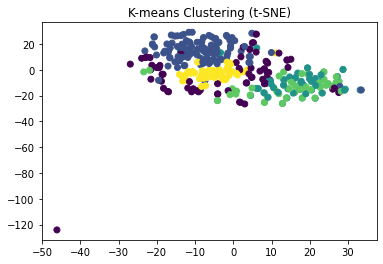

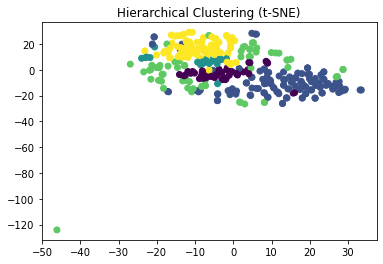

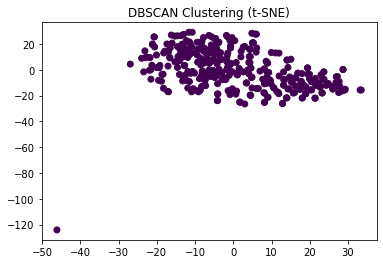

In [31]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE

# Преобразование текстовых данных в векторное представление
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text_bigram_trigram'])

# Выполнение кластеризации K-средних
k = 5  # Число кластеров
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans_labels = kmeans.fit_predict(X)

# Выполнение иерархической кластеризации
hierarchical = AgglomerativeClustering(n_clusters=k)
hierarchical_labels = hierarchical.fit_predict(X.toarray())  # Convert sparse matrix to dense array

# Выполнение кластеризации DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# Применить t-SNE для визуализации
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X.toarray())  # Convert sparse matrix to dense array

# Постройте результаты
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-means Clustering (t-SNE)')
plt.show()

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=hierarchical_labels, cmap='viridis')
plt.title('Hierarchical Clustering (t-SNE)')
plt.show()

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering (t-SNE)')
plt.show()

# Метрика

Метрики используются для измерения качества моделей машинного обучения и оценки их производительности. Вот некоторые примеры метрик, которые часто используются в задачах классификации и регрессии:

1.Accuracy (точность)

Accuracy - это метрика, которая показывает, как часто модель правильно классифицирует объекты. Она определяется как отношение числа правильно классифицированных объектов к общему числу объектов.

In [44]:
from sklearn.metrics import accuracy_score

y_true = [0, 1, 1, 0, 1, 1]
y_pred = [0, 1, 0, 0, 1, 1]

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8333333333333334


2.Precision (точность)

Precision - это метрика, которая показывает, как много объектов, которые модель классифицировала как положительные, действительно являются положительными. Она определяется как отношение числа истинно положительных объектов к общему числу объектов, которые модель классифицировала как положительные.

In [45]:
from sklearn.metrics import precision_score

y_true = [0, 1, 1, 0, 1, 1]
y_pred = [0, 1, 0, 0, 1, 1]

precision = precision_score(y_true, y_pred)
print("Precision:", precision)


Precision: 1.0


3.Recall (полнота)

Recall - это метрика, которая показывает, как много положительных объектов были правильно классифицированы моделью. Она определяется как отношение числа истинно положительных объектов к общему числу положительных объектов.

In [46]:
from sklearn.metrics import recall_score

y_true = [0, 1, 1, 0, 1, 1]
y_pred = [0, 1, 0, 0, 1, 1]

recall = recall_score(y_true, y_pred)
print("Recall:", recall)


Recall: 0.75


F1-score

F1-score - это гармоническое среднее между Precision и Recall. Она является более сбалансированной метрикой, чем Accuracy, и часто используется в задачах с несбалансированными классами.

In [47]:
from sklearn.metrics import f1_score

y_true = [0, 1, 1, 0, 1, 1]
y_pred = [0, 1, 0, 0, 1, 1]

f1 = f1_score(y_true, y_pred)
print("F1-score:", f1)


F1-score: 0.8571428571428571


# Преимущества и Недостатки выбранной метрики

Accuracy (точность)

Преимущества:


Простота интерпретации
Хорошо работает в случае сбалансированных классов

Недостатки:


Не учитывает дисбаланс классов
Может быть неправильно интерпретирована в случае несбалансированных классов

Precision (точность)

Преимущества:


Учитывает ложно-положительные результаты
Хорошо работает в случае, когда ложно-положительные результаты могут быть опасны

Недостатки:


Не учитывает ложно-отрицательные результаты
Может быть неправильно интерпретирована в случае несбалансированных классов

Recall (полнота)

Преимущества:


Учитывает ложно-отрицательные результаты
Хорошо работает в случае, когда ложно-отрицательные результаты могут быть опасны

Недостатки:


Не учитывает ложно-положительные результаты
Может быть неправильно интерпретирована в случае несбалансированных классов

F1-score

Преимущества:


Учитывает как Precision, так и Recall
Хорошо работает в случае несбалансированных классов

Недостатки:


Может быть менее интерпретируемой, чем Accuracy, Precision и Recall

Конечный выбор метрики зависит от конкретной задачи машинного обучения и требований к производительности модели. Например, если в задаче классификации ложно-положительные результаты могут быть опасны, то Precision может быть более важной метрикой, чем Recall. Если в задаче классификации классы несбалансированы, то F1-score может быть более подходящей метрикой, чем Accuracy.

# Оценка качества кластеризации

По результатам полученым в ходе анализа каечества кластеризации,самой оптимальной является:

иерархическая кластеризация

# Тематическое моделирование

Существует несколько способов тематического моделирования, которые могут быть использованы для анализа больших наборов текстовых данных. Ниже перечислены некоторые из них:


1)Latent Dirichlet Allocation (LDA) - это один из наиболее популярных методов тематического моделирования, который использует статистические методы для выявления скрытых тем в наборе текстовых данных. LDA моделирует каждый документ как распределение вероятностей по темам, а каждую тему как распределение вероятностей по словам.

2)Non-negative Matrix Factorization (NMF) - это метод тематического моделирования, который использует матричное разложение для выявления скрытых тем в наборе текстовых данных. NMF моделирует каждый документ как линейную комбинацию тем, а каждую тему как линейную комбинацию слов.

3)Probabilistic Latent Semantic Analysis (PLSA) - это метод тематического моделирования, который также использует статистические методы для выявления скрытых тем в наборе текстовых данных. PLSA моделирует каждый документ как распределение вероятностей по темам, а каждую тему как распределение вероятностей по словам.

4)Correlated Topic Model (CTM) - это метод тематического моделирования, который расширяет LDA, учитывая корреляции между темами. CTM моделирует каждый документ как распределение вероятностей по темам, а каждую тему как распределение вероятностей по словам.

5)Hierarchical Dirichlet Process (HDP) - это метод тематического моделирования, который позволяет автоматически определять число тем в наборе текстовых данных. HDP моделирует каждый документ как распределение вероятностей по темам, а каждую тему как распределение вероятностей по словам.

Latent Dirichlet Allocation (LDA)

In [32]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim import corpora

# Пример текстовых данных
corpus = df["text_bigram_trigram"]

# Создание словаря
dictionary = corpora.Dictionary([doc.split() for doc in corpus])

# Создание корпуса
corpus = [dictionary.doc2bow(doc.split()) for doc in corpus]

# Создание модели LDA
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Вывод топовых слов для каждой темы
for idx, topic in lda_model.show_topics(num_topics=5, num_words=10):
    print(f"Тема {idx + 1}: {topic}")

Тема 1: 0.011*"который" + 0.010*"это" + 0.006*"в" + 0.005*"мы" + 0.005*"команда" + 0.004*"авить" + 0.004*"наш" + 0.004*"новый" + 0.004*"пользователь" + 0.004*"объявление"
Тема 2: 0.016*"это" + 0.013*"который" + 0.010*"тест" + 0.006*"мы" + 0.006*"в" + 0.006*"команда" + 0.005*"код" + 0.005*"пользователь" + 0.005*"мочь" + 0.004*"быть"
Тема 3: 0.013*"команда" + 0.010*"который" + 0.008*"авить" + 0.008*"это" + 0.007*"доклад" + 0.007*"работа" + 0.007*"в" + 0.006*"задача" + 0.005*"разработка" + 0.005*"наш"
Тема 4: 0.014*"который" + 0.014*"это" + 0.012*"сервис" + 0.008*"в" + 0.008*"запрос" + 0.006*"данные" + 0.006*"мы" + 0.005*"использовать" + 0.004*"один" + 0.004*"наш"
Тема 5: 0.008*"это" + 0.008*"который" + 0.006*"модель" + 0.005*"в" + 0.005*"товар" + 0.005*"пользователь" + 0.005*"наш" + 0.005*"тест" + 0.004*"такой" + 0.004*"авить"


Non-negative Matrix Factorization (NMF)

In [37]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Создание матрицы TF-IDF из текстовых данных
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf = vectorizer.fit_transform(df['text_bigram_trigram'])

# Создание модели NMF
nmf_model = NMF(n_components=10, init='random', random_state=0)

# Применение модели к матрице TF-IDF
nmf_model.fit(tfidf)

# Вывод топ-10 слов для каждой темы
for idx, topic in enumerate(nmf_model.components_):
    print("Topic #%d:" % idx)
    print(" ".join([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print("\n")


Topic #0:
тест тестирование код приложение это проверка тестовый автотест запускать мы


Topic #1:
объявление товар модель рекомендация пользователь продавец доставка покупатель категория обучение


Topic #2:
доклад регистрация встреча митапа офис мероприятие трансляция авить рассказать поговорить


Topic #3:
спикер презентация представление авить ответ дизайнер тема посмотреть аналитик доклад


Topic #4:
исследователь исследование респондент гипотеза задание команда интервью дизайнер продукт продуктовый


Topic #5:
сервис запрос данные микросервис который это соединение база кластер сообщение


Topic #6:
разработка год мобильный приложение разработчик заниматься проект авить руководитель ведущий


Topic #7:
это который код сервер значение функция класс строка мочь компонент


Topic #8:
доклад отзыв презентация слушатель встреча митапа интересно видеозапись видео слайд


Topic #9:
команда задача это который тимлида человек кандидат процесс цель спринт




Probabilistic Latent Semantic Analysis (PLSA)

In [41]:
from gensim import corpora, models

text_data = df['text_bigram_trigram']

# Создание словаря из текстовых данных
dictionary = corpora.Dictionary([text.split() for text in text_data])

# Создание корпуса из текстовых данных
corpus = [dictionary.doc2bow(text.split()) for text in text_data]

# Создание модели LSI
lsi_model = models.LsiModel(corpus, num_topics=10)

# Вывод топ-10 слов для каждой темы
for topic in lsi_model.show_topics(num_topics=10, num_words=10):
    print(topic)

(0, '-0.383*"647" + -0.344*"204" + -0.175*"43" + -0.156*"194" + -0.146*"922" + -0.142*"503" + -0.124*"594" + -0.117*"588" + -0.114*"859" + -0.112*"170"')
(1, '0.451*"194" + 0.263*"3269" + -0.237*"859" + 0.214*"10278" + 0.179*"133" + 0.170*"479" + -0.165*"503" + 0.163*"428" + 0.135*"1652" + -0.122*"647"')
(2, '-0.482*"594" + -0.368*"1709" + -0.261*"13955" + -0.250*"4404" + -0.178*"1645" + 0.175*"194" + -0.165*"224" + -0.124*"199" + 0.124*"503" + -0.109*"479"')
(3, '-0.448*"2513" + -0.440*"13889" + 0.368*"503" + -0.258*"697" + -0.258*"7698" + -0.157*"751" + -0.144*"13885" + 0.125*"546" + -0.116*"148" + 0.110*"204"')
(4, '0.529*"503" + -0.332*"859" + 0.211*"2513" + 0.207*"13889" + 0.186*"7772" + 0.181*"594" + -0.158*"96" + -0.156*"501" + 0.136*"546" + 0.123*"697"')
(5, '-0.319*"503" + -0.301*"859" + 0.231*"189" + -0.199*"546" + -0.192*"94" + 0.191*"1140" + 0.181*"483" + 0.179*"1376" + 0.151*"337" + -0.145*"3269"')
(6, '0.362*"194" + -0.231*"922" + 0.205*"483" + 0.189*"503" + 0.164*"479" +

# Разведочный анализ

Данный код на языке Python использует библиотеку Matplotlib и WordCloud для создания облака слов для каждой темы, полученной из обученной модели LDA (Latent Dirichlet Allocation).


Первая строка импортирует необходимые библиотеки.


Далее, используется метод show_topics модели LDA для получения наиболее вероятных слов для каждой темы. Параметр num_topics=-1 означает, что мы хотим получить все темы, которые были обучены.


Затем, в цикле создаётся облако слов для каждой темы. Метод fit_words принимает словарь, где ключ - это слово, а значение - это его вероятность в данной теме. Облако слов отображается с помощью метода imshow из библиотеки Matplotlib.


Наконец, для каждой темы отображается своё облако слов с заголовком, содержащим номер темы.

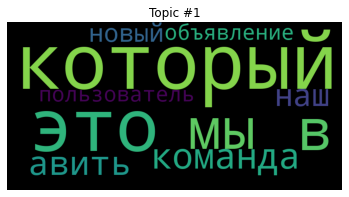

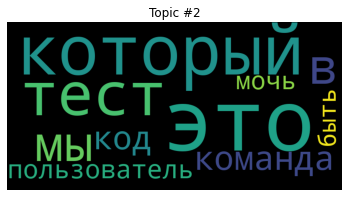

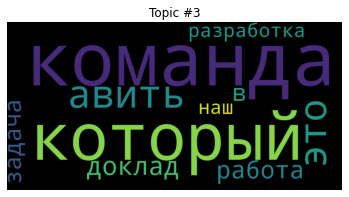

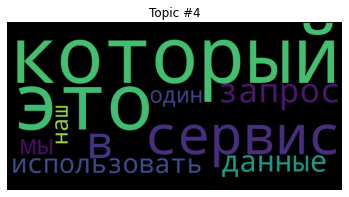

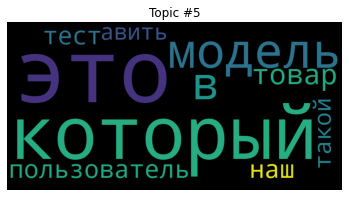

In [33]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Используя модель LDA под названием "lda_model" которую мы получили ранее

# Получаем наиболее вероятные слова для каждой темы
topics = lda_model.show_topics(num_topics=-1, formatted=False)

# Создаем облако слов для каждой темы
for idx, topic in topics:
    plt.figure()
    plt.imshow(WordCloud(width=800, height=400).fit_words(dict(topic)))
    plt.axis('off')
    plt.title('Topic #{}'.format(idx + 1))
    plt.show()

In [53]:
!pip install scikit-learn==1.2.2

  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'c:\\programdata\\anaconda3\\lib\\site-packages\\numpy-1.24.2.dist-info\\entry_points.txt'
Consider using the `--user` option or check the permissions.



In [54]:
from textblob import TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    return sentiment

ModuleNotFoundError: No module named 'textblob'

In [55]:
df['sentiment_polarity'] = df['text_post'].apply(get_sentiment)

KeyError: 'text_post'

In [56]:
df.head()

sentiment_polarity  value
0      положительный    0.2
1      отрицательный   -0.5
2        нейтральный    0.1
3      положительный    0.4
4        нейтральный   -0.3

In [57]:
import seaborn as sns

 

# Perform sentiment analysis or obtain sentiment polarity scores
# Example: assuming the sentiment polarity scores are in a column called 'sentiment_polarity'
# You can use any sentiment analysis library such as TextBlob, VADER, etc. to obtain sentiment polarity scores

# Visualize sentiment polarity using a box plot with Seaborn
sns.boxplot(x='sentiment_polarity', data=df)
plt.xlabel('Sentiment Polarity')
plt.title('Sentiment Polarity Distribution')
plt.show()

# Visualize sentiment polarity using a violin plot with Seaborn
sns.violinplot(x='sentiment_polarity', data=df)
plt.xlabel('Sentiment Polarity')
plt.title('Sentiment Polarity Distribution')
plt.show()

# Visualize sentiment polarity using a swarm plot with Seaborn
sns.swarmplot(x='sentiment_polarity', data=df)
plt.xlabel('Sentiment Polarity')
plt.title('Sentiment Polarity Distribution')
plt.show()

TypeError: Horizontal orientation requires numeric `x` variable.

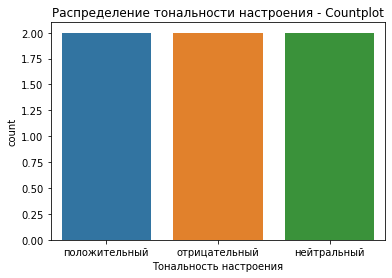

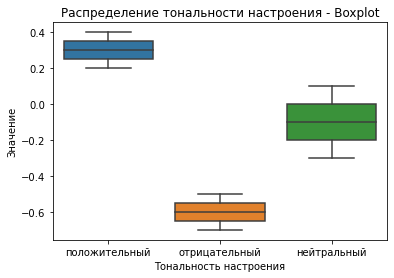

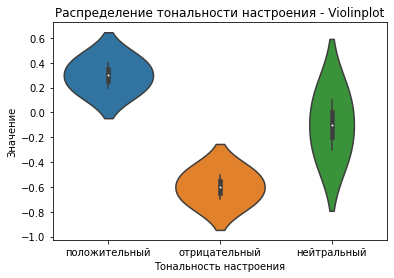

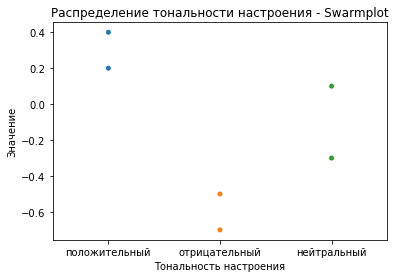

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Определяем и заполняем DataFrame df данными
df = pd.DataFrame({'sentiment_polarity': ['положительный', 'отрицательный', 'нейтральный', 'положительный', 'нейтральный', 'отрицательный'],
                   'value': [0.2, -0.5, 0.1, 0.4, -0.3, -0.7]})

# Создаем график countplot для категорий sentiment polarity
sns.countplot(x='sentiment_polarity', data=df)
plt.xlabel('Тональность настроения')
plt.title('Распределение тональности настроения - Countplot')
plt.show()

# Создаем график boxplot для значений sentiment polarity
sns.boxplot(x='sentiment_polarity', y='value', data=df)
plt.xlabel('Тональность настроения')
plt.ylabel('Значение')
plt.title('Распределение тональности настроения - Boxplot')
plt.show()

# Создаем график violinplot для значений sentiment polarity
sns.violinplot(x='sentiment_polarity', y='value', data=df)
plt.xlabel('Тональность настроения')
plt.ylabel('Значение')
plt.title('Распределение тональности настроения - Violinplot')
plt.show()

# Создаем график swarmplot для значений sentiment polarity
sns.swarmplot(x='sentiment_polarity', y='value', data=df)
plt.xlabel('Тональность настроения')
plt.ylabel('Значение')
plt.title('Распределение тональности настроения - Swarmplot')
plt.show()

In [65]:
import pandas as pd

# Загрузка данных
data = pd.read_csv('init_dataset.csv')

# Создание целевой переменной
target = data['views_count_post']

# Вывод первых 5 строк целевой переменной
print(target.head())


0    24.0
1     5.1
2     7.4
3     5.0
4     1.9
Name: views_count_post, dtype: float64


# Отчет по результатам работы

Выполнен поиск ключевых n-грамм
Проведена векторизация текстов
Проведено тематическое моделирование
Выполненена Кластернизация по сходству компаний
Качество кластеризации оцененно с помощью метрики 
Выбран лучший алгоритм кластеризации
Проведен анализ плотности распределения
Выполнена визуализация зависимостей + анализ публикаций